# Machine Learning Basics

In [1]:
import numpy as np
import pandas as pd
import scipy.io
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.covariance import empirical_covariance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.datasets import load_iris
from sklearn.tree import plot_tree

## KNN (K-Nearest Neighbors)
- [Machine Learning](https://ailearning.apachecn.org/#/docs/ml/1)
- [K-Nearest Neighbors](https://zhuanlan.zhihu.com/p/28656126)
- Rewrite and reproduce Helen's dated KNN if time permits.

In [3]:
def load_data(file_path='data/datingTestSet2.txt', disp=True, header=None, delimiter=',', cols=None):
    df = pd.read_csv(file_path, header=header, delimiter=delimiter)
    if cols:
        df.columns = cols
    if disp:
        display(df.head())
    return df

colnames = ['miles_yr', 'game_pct', 'icecream_gal', 'class']
helen_df = load_data(delimiter='\t', cols=colnames)

miles_yr   game_pct  icecream_gal  class
0     40920   8.326976      0.953952      3
1     14488   7.153469      1.673904      2
2     26052   1.441871      0.805124      1
3     75136  13.147394      0.428964      1
4     38344   1.669788      0.134296      1

In [4]:
def apply_knn(data, y_colname, neighbor_count=5, norm=True, test_ratio=0.2, seed=1):
    y = data['class'].to_numpy()
    X = data.drop(['class'], axis=1).to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=seed)
    decor = 'un'

    if norm:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        decor = ''

    knn = KNeighborsClassifier(n_neighbors=neighbor_count)
    knn.fit(X_train, y_train)
    preds = knn.predict(X_test)
    acc_pct = 100*sum(preds==y_test)/len(preds)
    print(f'Prediction Accuracy ({decor}normalized X): {acc_pct}%')

    return knn

apply_knn(helen_df, 'class', norm=False)
apply_knn(helen_df, 'class');

Prediction Accuracy (unnormalized X): 79.0%
Prediction Accuracy (normalized X): 94.0%


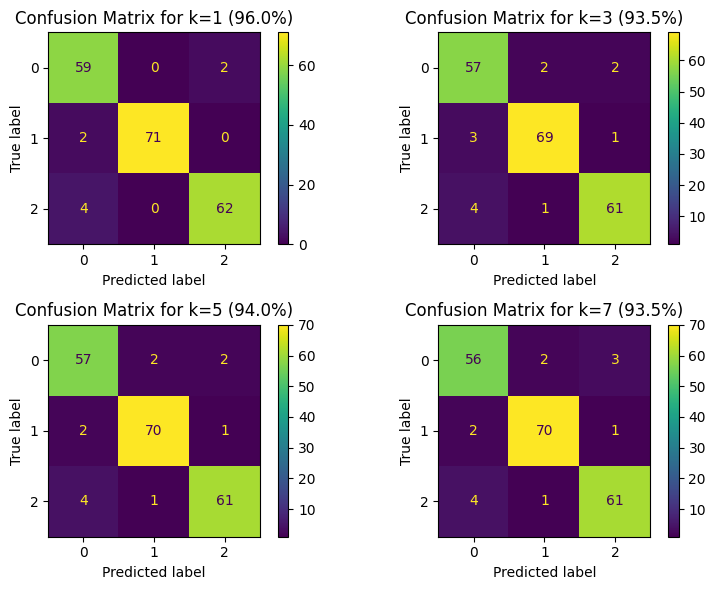

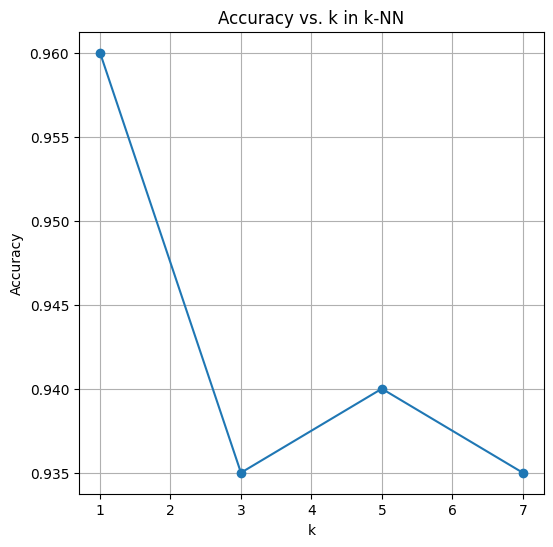

In [5]:
def apply_knn(data, y_colname, norm=True, test_ratio=0.2, seed=1, k_values=[1, 3, 5, 7]):
    y = data[y_colname].to_numpy()
    X = data.drop([y_colname], axis=1).to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=seed)
    
    if norm:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    results = []

    fig, axs = plt.subplots(2, 2, figsize=(8, 6))
    
    for i, k in enumerate(k_values):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        acc = accuracy_score(y_test, preds)
        results.append((k, acc))

        cm = confusion_matrix(y_test, preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        ax_cm = axs[i // 2, i % 2]
        disp.plot(ax=ax_cm, values_format='d', cmap='viridis')
        ax_cm.set_title(f'Confusion Matrix for k={k} ({acc*100:.1f}%)')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 6))

    ks, accs = zip(*results)
    plt.plot(ks, accs, marker='o')
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. k in k-NN')
    plt.grid(True)
    plt.show()

apply_knn(helen_df, 'class', norm=True, k_values=[1, 3, 5, 7])

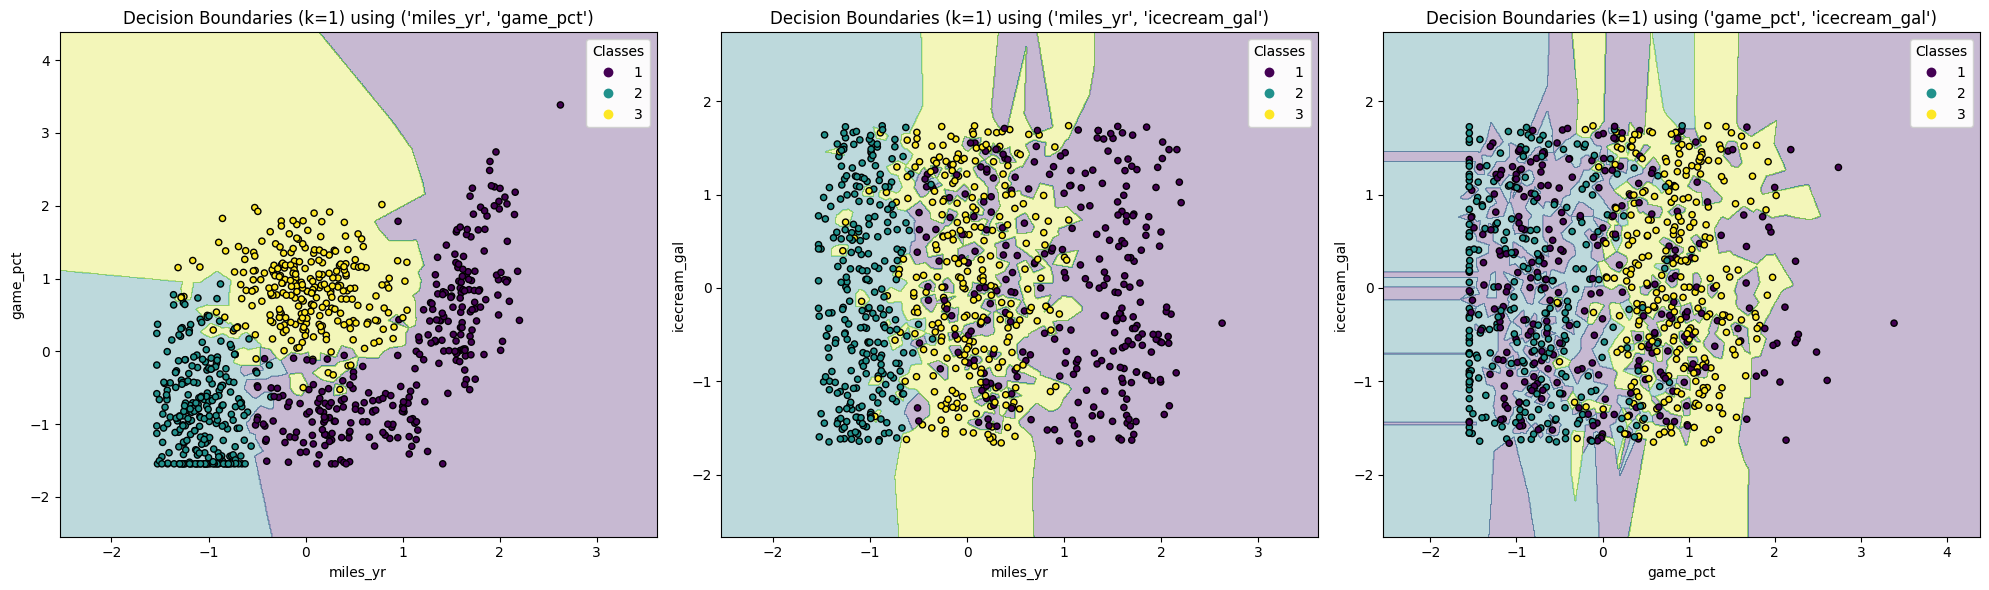

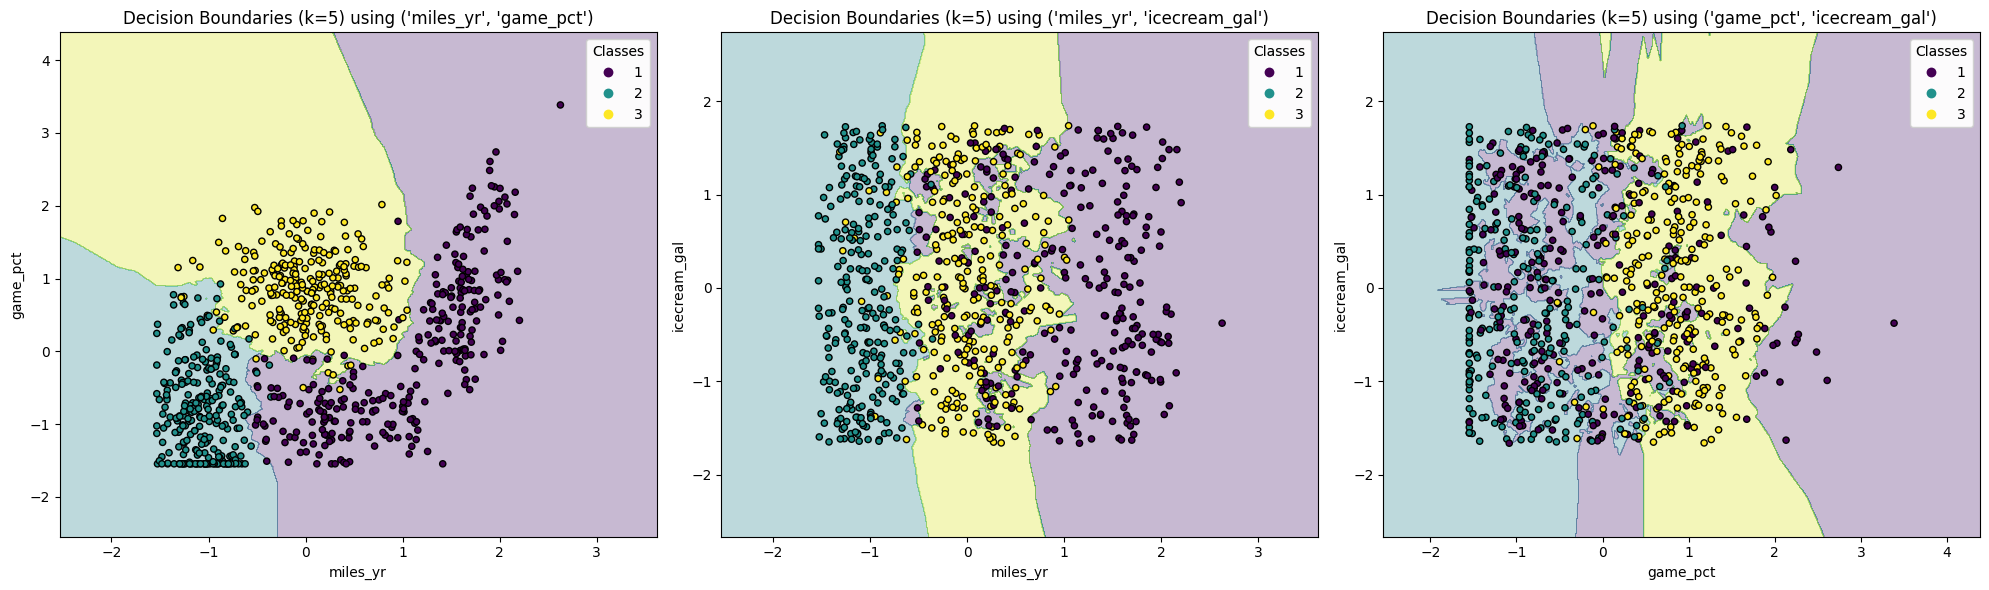

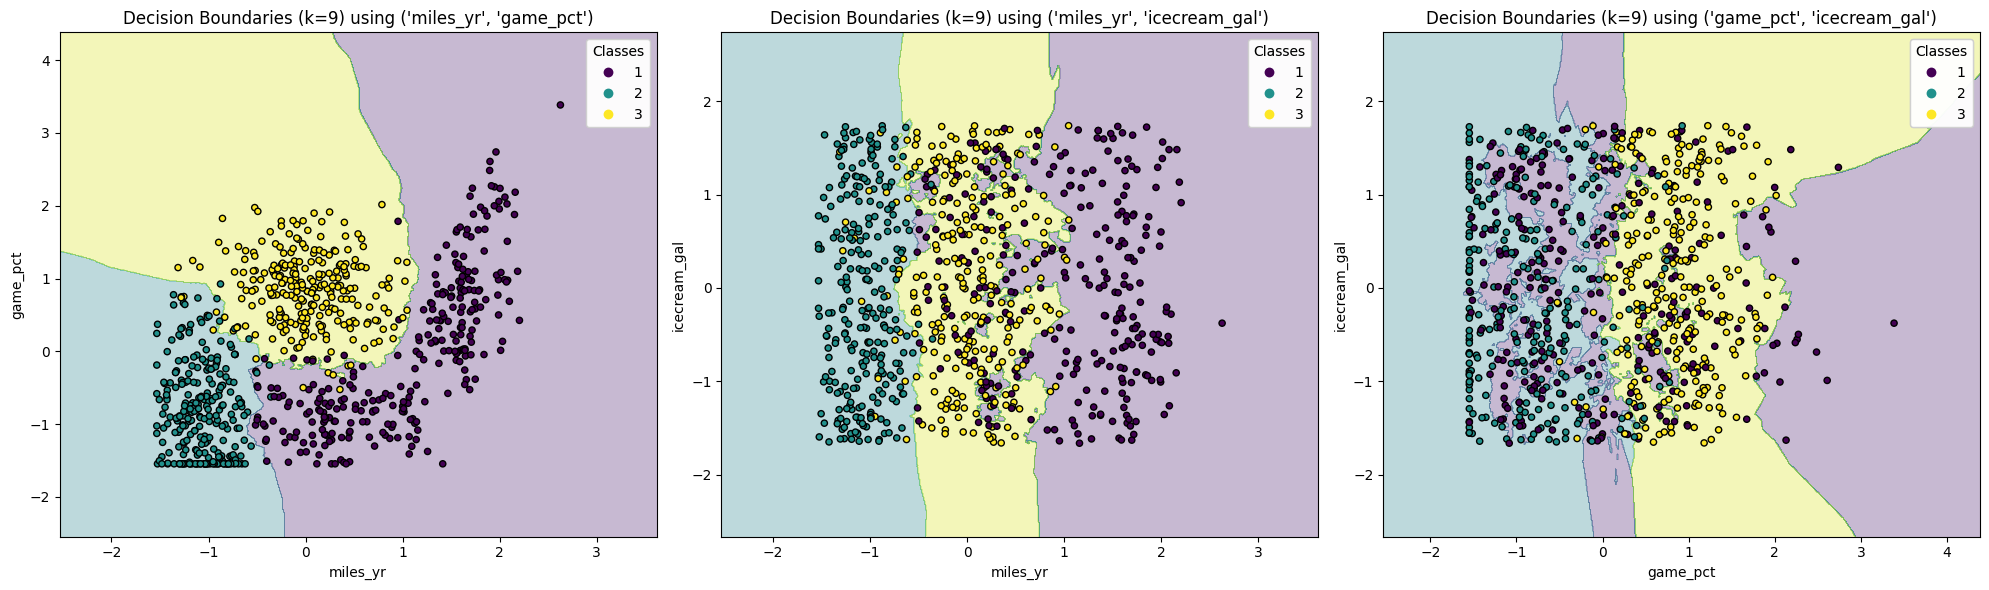

In [6]:
def plot_decision_boundaries(X, y, model, feature_pair, ax, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', s=20)
    legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
    ax.add_artist(legend1)
    ax.set_xlabel(feature_pair[0])
    ax.set_ylabel(feature_pair[1])
    ax.set_title(title)

def apply_knn_on_pairs(data, y_colname, feature_pairs, norm=True, k=5, test_ratio=0.2, seed=1):
    y = data[y_colname].to_numpy()
    
    if norm:
        scaler = StandardScaler()
        data_scaled = pd.DataFrame(scaler.fit_transform(data.drop([y_colname], axis=1)), columns=data.columns[:-1])
        data_scaled[y_colname] = y
    else:
        data_scaled = data
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for i, feature_pair in enumerate(feature_pairs):
        X = data_scaled[list(feature_pair)].to_numpy()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=seed)
        
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        
        preds = knn.predict(X_test)
        acc = accuracy_score(y_test, preds)

        plot_decision_boundaries(X_train, y_train, knn, feature_pair, axs[i], f'Decision Boundaries (k={k}) using {feature_pair}')
    
    plt.tight_layout()
    plt.show()

feature_pairs = [('miles_yr', 'game_pct'), ('miles_yr', 'icecream_gal'), ('game_pct', 'icecream_gal')]
apply_knn_on_pairs(helen_df, 'class', feature_pairs, norm=True, k=1)
apply_knn_on_pairs(helen_df, 'class', feature_pairs, norm=True, k=5)
apply_knn_on_pairs(helen_df, 'class', feature_pairs, norm=True, k=9)

#### The combination of miles_yr and game_pct seems to be able to properly segment the population into 3 groups.  

#### As k-value increases, decision boundaries get smoother (and likely more robust), at the expense of the classification accuracy of the dataset slightly decreasing.

## Decision Tree
- [Decision Tree 1](https://cuijiahua.com/blog/2017/11/ml_2_decision_tree_1.html)
- [Decision Tree 2](https://cuijiahua.com/blog/2017/11/ml_3_decision_tree_2.html)
- **Acceptance Requirements:**
  - Handwritten decision tree for classification of the iris dataset.

Prediction Accuracy: 96.66666666666667%


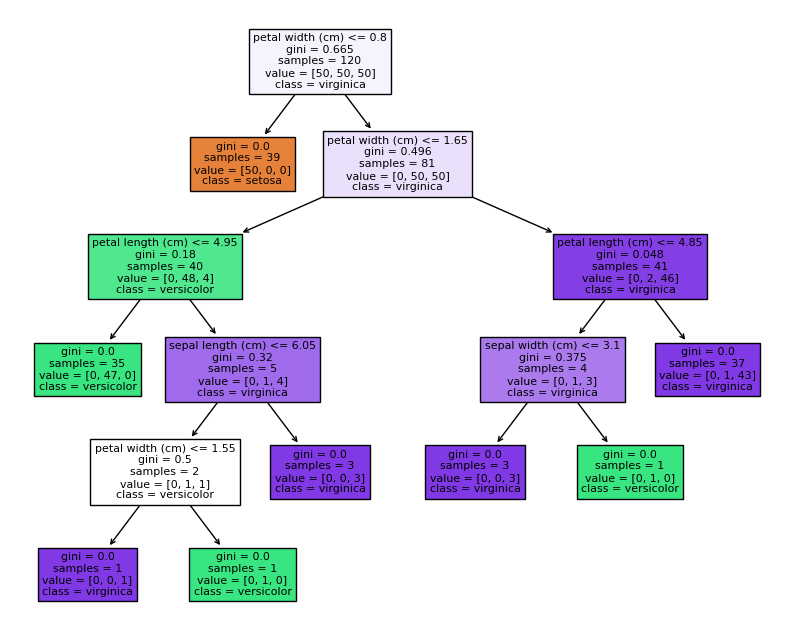

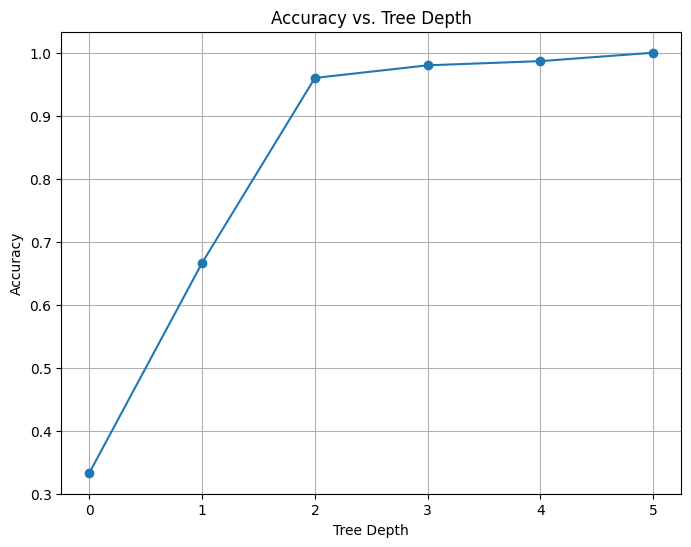

In [7]:
def prepare_tree(data, test_ratio=0.2, seed=1):
    X = data.data
    y = data.target
    split = train_test_split(X, y, test_size=test_ratio, random_state=seed)
    return split

def fit_tree(X_train, X_test, y_train, y_test, seed=1):
    tree_clf = DecisionTreeClassifier(random_state=seed)
    tree_clf.fit(X_train, y_train)
    preds = tree_clf.predict(X_test)
    acc_pct = 100*sum(preds==y_test)/len(preds)

    print(f'Prediction Accuracy: {acc_pct}%')

    return tree_clf

def plot_tree_with_test(tree_clf, tree_plot, X_test, y_test):
    n = len(tree_plot)
    category = tree_clf.n_classes_
    path = tree_clf.decision_path(X_test).toarray().transpose()
    for i in range(n):
        value = []
        for j in range(category):
            value += [sum(y_test[path[i]==1]==j)]
        value = np.array(value)
        og_text = tree_plot[i].get_text()
        back = og_text.split(']')[1]
        front = og_text.split('[')[0]
        og_counts = np.array([int(n.strip()) for n in og_text.split('[')[1].split(']')[0].split(',')])
        vals_str = ', '.join([str(v) for v in value+og_counts])
        tree_plot[i].set_text(f'{front}[{vals_str}]{back}')

    return tree_plot

def plot_tree_with_test(tree_clf, tree_plot, X_test, y_test):
    n = len(tree_plot)
    category = tree_clf.n_classes_
    path = tree_clf.decision_path(X_test).toarray().transpose()
    for i in range(n):
        value = []
        for j in range(category):
            value += [sum(y_test[path[i]==1]==j)]
        value = np.array(value)
        og_text = tree_plot[i].get_text()
        back = og_text.split(']')[1]
        front = og_text.split('[')[0]
        og_counts = np.array([int(n.strip()) for n in og_text.split('[')[1].split(']')[0].split(',')])
        vals_str = ', '.join([str(v) for v in value+og_counts])
        tree_plot[i].set_text(f'{front}[{vals_str}]{back}')

    return tree_plot

iris_data = load_iris()
X = iris_data.data
y = iris_data.target
X_train, X_test, y_train, y_test = prepare_tree(iris_data)
tree_clf = fit_tree(X_train, X_test, y_train, y_test)

fig = plt.figure(figsize=(10,8))
tree_plot = plot_tree(tree_clf, feature_names=iris_data.feature_names, class_names=iris_data.target_names, filled=True)
tree_plot = plot_tree_with_test(tree_clf, tree_plot, X_test, y_test)
plt.show()

layer_accuracies = [(150-k)/150 for k in [100,50,6,3,2,0]]
plt.figure(figsize=(8, 6))
plt.plot(range(len(layer_accuracies)), layer_accuracies, marker='o')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Tree Depth')
plt.grid(True)
plt.show()

#### As the depth/layer of the decision tree increases, decision boundaries gets more sharded, and classification accuracy increases at the expense of the robustness, generalizability, and interpretability of the classifications slightly decreasing.

### Naive Bayes (Naive Bayes)
- [Naive Bayes](https://cuijiahua.com/blog/2017/11/ml_4_bayes_1.html)

### SVM (Support Vector Machines)
- [Support Vector Machines 1](https://cuijiahua.com/blog/2017/11/ml_8_svm_1.html)
- [Support Vector Machines 2](https://cuijiahua.com/blog/2017/11/ml_9_svm_2.html)

### Apriori
- [Apriori](https://ailearning.apachecn.org/#/docs/ml/11)

### FP-Growth
- [FP-Growth](https://ailearning.apachecn.org/#/docs/ml/12)

## PCA (Principal Component Analysis)
- [Principal Component Analysis 1](https://ailearning.apachecn.org/ailearning/#/docs/ml/13)
- [Principal Component Analysis 2](https://zhuanlan.zhihu.com/p/57062158)
- **Acceptance Requirements:**
  - Implement PCA dimensionality reduction on `ex7faces.mat`, reducing from 1024 dimensions to 100 dimensions.

#### The point of PCA is dimensionality reduction. The primary motivations for using PCA are data compression, feature extraction, and noise reduction.

1. Data Compression: The original dataset often contains high-dimensional data, which can be computationally expensive to process. Transforming them into linear combinations of the original variables greatly enhances calculations.

2. Feature Extraction: PCA identifies the directions along which the variance of the data is maximized, helping us find the most important features while discarding the less significant ones.

3. PCA effectively filters out noise (captured by the components with smaller eigenvalues) by keeping only the top principal components.

#### An alternate method is t-SNE. It is excellent for visualization and capturing local structure but computationally expensive and doesn't scale well to large datasets.

(5000, 1024) (5000, 100)


c:\Users\Jim\anaconda3\envs\dd\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\Jim\anaconda3\envs\dd\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


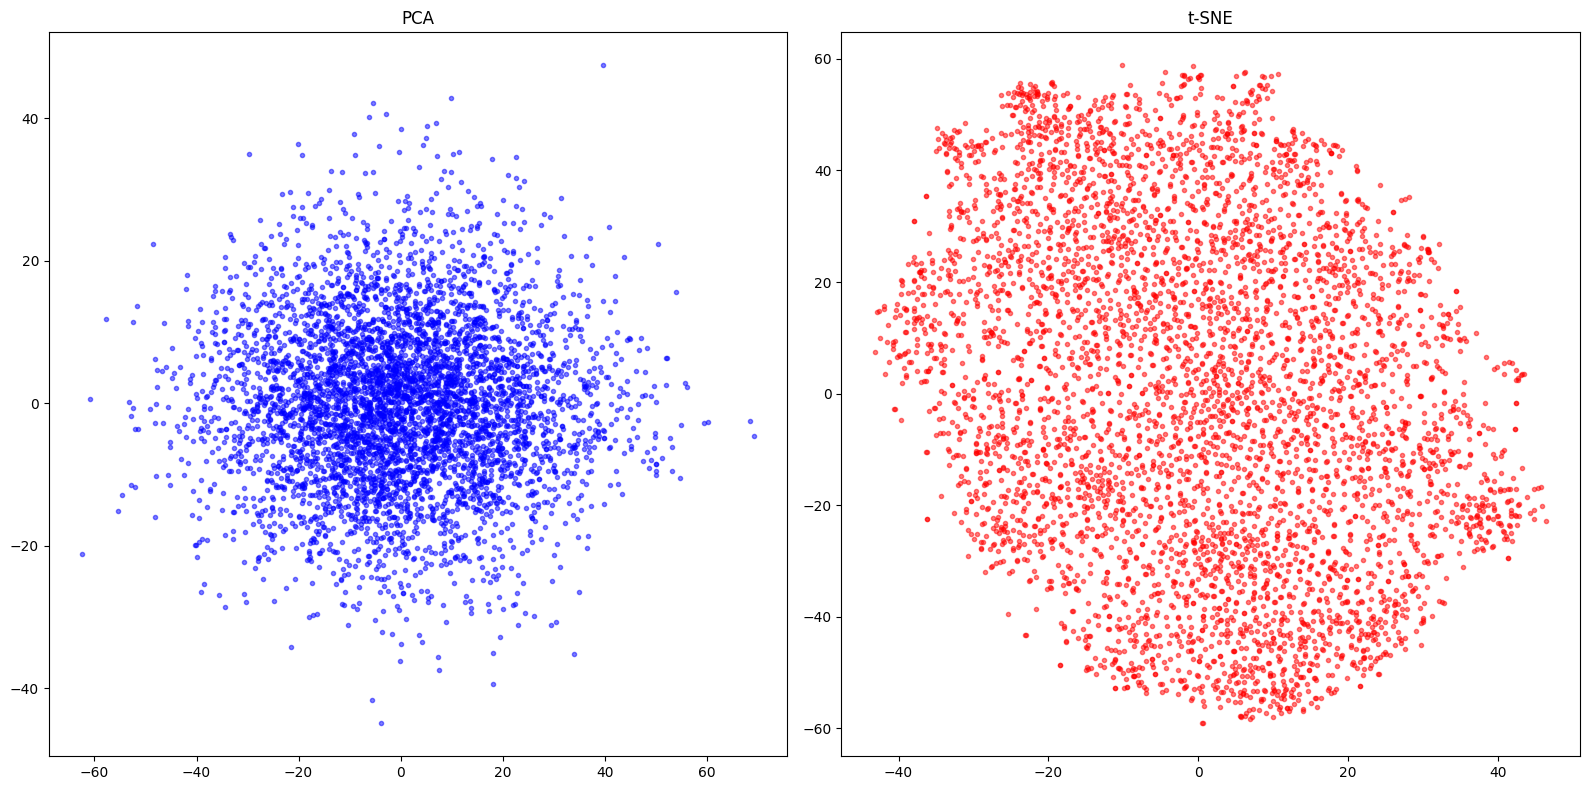

In [8]:
mat = scipy.io.loadmat('data/ex7faces.mat')['X']
mat_normalized = StandardScaler().fit(mat).transform(mat)
n_components = 100

pca = PCA(n_components=n_components).fit(mat_normalized)
X_pca = pca.transform(mat_normalized)
print(mat_normalized.shape, X_pca.shape)
data_pca = pca.fit_transform(mat_normalized)

n_components_tsne = 2
tsne = TSNE(n_components=n_components_tsne, random_state=42)
data_tsne = tsne.fit_transform(mat_normalized)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(data_pca[:, 0], data_pca[:, 1], marker='.', c='b', alpha=0.5)
plt.title('PCA')
plt.subplot(1, 2, 2)
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], marker='.', c='r', alpha=0.5)
plt.title('t-SNE')
plt.tight_layout()
plt.show()

(5000, 1024) (5000, 100)
Shape U: (5000, 100)
Shape s: (100,)
Shape Vt: (100, 1024)

Error of X approximation:
 [[ 1.02e-01 -8.82e-02 -2.30e-01 ... -2.21e-01 -3.41e-01 -4.12e-01]
 [-1.26e+00  1.49e+00 -4.73e-01 ... -1.93e-01  3.27e-02  1.87e+01]
 [ 5.68e-02 -5.18e-02 -2.52e-01 ... -1.71e-02  5.32e-03 -8.69e-03]
 ...
 [-2.17e-01  3.24e-01  2.26e+00 ... -2.61e-01 -3.33e-02  3.85e-01]
 [-7.81e-01 -4.14e-01  1.89e-01 ...  2.86e-01  5.01e-03 -2.35e-01]
 [ 6.02e-02  9.07e-02  1.07e-01 ... -2.46e-01  1.97e-01  1.78e-01]]


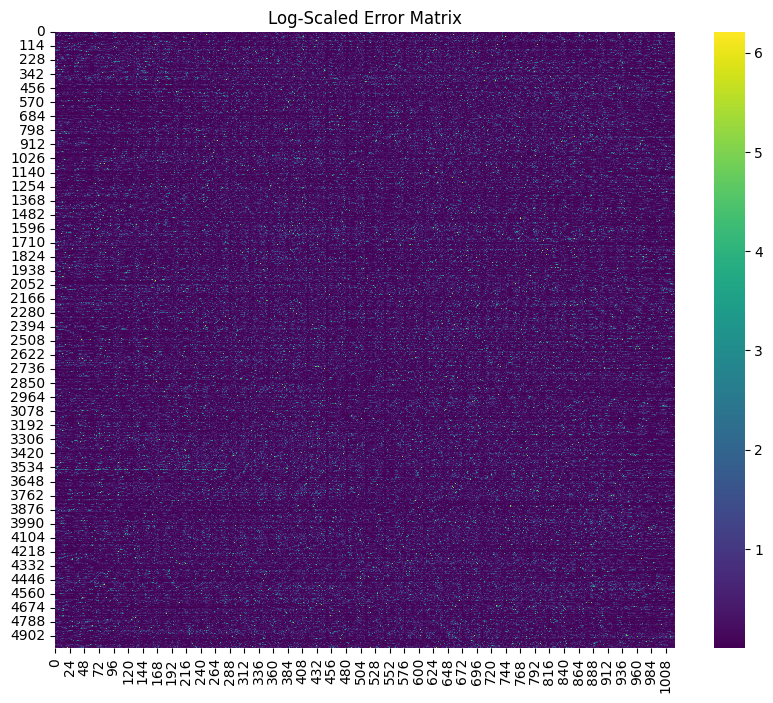

In [9]:
np.set_printoptions(precision=2)
np.random.seed(42)

n_components = 100
pca = PCA(n_components=n_components)
data_pca = pca.fit_transform(mat_normalized)

print(mat_normalized.shape, data_pca.shape)

U, s, Vt = svds(mat, k=n_components)
sigma = np.zeros((n_components, n_components))
np.fill_diagonal(sigma, s)

print(f'Shape U: {U.shape}')
print(f'Shape s: {s.shape}')
print(f'Shape Vt: {Vt.shape}')

X_approx = U @ sigma @ Vt
error_mat = (X_approx - mat) / mat

print("\nError of X approximation:\n", error_mat)

plt.figure(figsize=(10, 8))
sns.heatmap(np.log1p(np.abs(error_mat)), cmap='viridis')
plt.title('Log-Scaled Error Matrix')
plt.show()

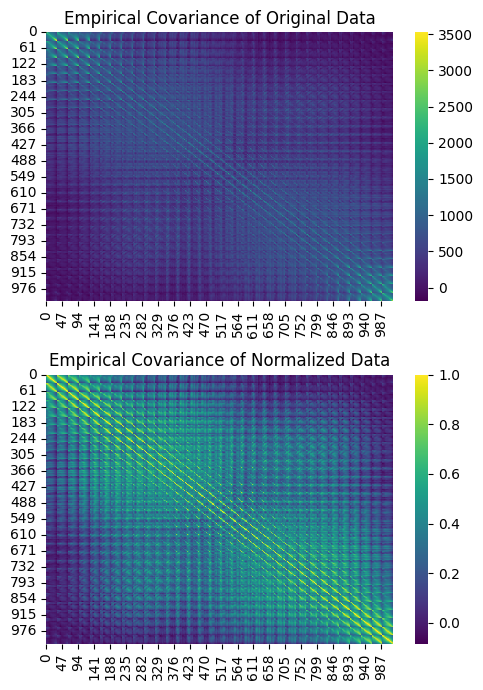

In [10]:
fig, axs = plt.subplots(2, figsize=(5, 7))

sns.heatmap(empirical_covariance(mat), ax=axs[0], cmap='viridis')
axs[0].set_title('Empirical Covariance of Original Data')

sns.heatmap(empirical_covariance(mat_normalized), ax=axs[1], cmap='viridis')
axs[1].set_title('Empirical Covariance of Normalized Data')

plt.tight_layout()
plt.show()

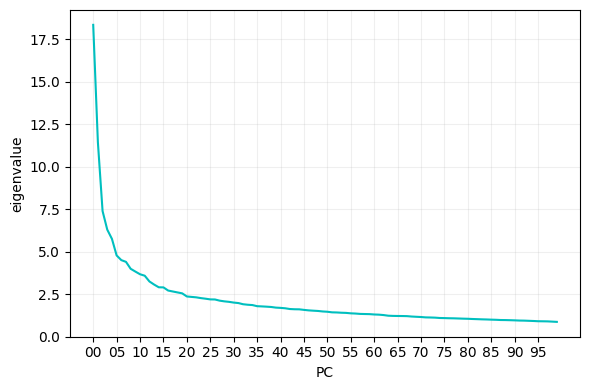

In [11]:
df = pd.DataFrame(
    {
        "eigenvalue": np.sqrt(pca.explained_variance_),
        "PC": [str(i) if len(str(i))==2 else '0' + str(i) for i in range(n_components)],
    }
)

plt.figure(figsize=(6, 4))
plt.grid(alpha=0.2)
sns.lineplot(x="PC", y="eigenvalue", data=df, color="c")
plt.xticks(np.arange(0, n_components, 5), [df["PC"][i] for i in range(0, n_components, 5)])
plt.tight_layout()
plt.show()

## SVD (Singular Value Decomposition)
- [Singular Value Decomposition 1](https://zhuanlan.zhihu.com/p/130439386)
- [Singular Value Decomposition 2](https://www.imooc.com/article/267351)

In [12]:
U, s, V = svds(mat, k=n_components)
sigma = np.zeros((n_components, n_components))

for i in range(n_components - 1):
    sigma[i, i] = s[i]

print(f'X original: {mat.shape}', '\n', mat)

X original: (5000, 1024) 
 [[ -37.87  -45.87  -53.87 ... -110.87 -111.87  -99.87]
 [   8.13   -0.87   -8.87 ...  -34.87   -8.87    0.13]
 [ -32.87  -34.87  -36.87 ... -110.87 -111.87 -111.87]
 ...
 [ -46.87  -24.87   -8.87 ...   90.13   80.13   59.13]
 [  19.13   16.13   14.13 ...  -38.87  -41.87  -46.87]
 [-108.87 -106.87 -102.87 ...   17.13   17.13   18.13]]


In [13]:
print(f'Shape U_matrix: {U.shape}', '\n', U)
print('\n', f'Shape sigma_matrix: {s.shape}', '\n', sigma)
print('\n', f'Shape V_T_matrix: {V.shape}', '\n', V)

Shape U_matrix: (5000, 100) 
 [[-0.01  0.    0.01 ... -0.01  0.02  0.01]
 [ 0.   -0.01  0.01 ...  0.    0.01  0.01]
 [-0.01 -0.02  0.01 ...  0.01  0.01 -0.01]
 ...
 [-0.02 -0.01  0.01 ... -0.01  0.01  0.01]
 [-0.    0.    0.   ...  0.    0.01  0.03]
 [ 0.01  0.    0.02 ... -0.    0.01  0.01]]

 Shape sigma_matrix: (100,) 
 [[ 2524.94     0.       0.   ...     0.       0.       0.  ]
 [    0.    2539.58     0.   ...     0.       0.       0.  ]
 [    0.       0.    2584.82 ...     0.       0.       0.  ]
 ...
 [    0.       0.       0.   ... 33965.52     0.       0.  ]
 [    0.       0.       0.   ...     0.   42714.88     0.  ]
 [    0.       0.       0.   ...     0.       0.       0.  ]]

 Shape V_T_matrix: (100, 1024) 
 [[ 0.04  0.02 -0.   ... -0.03 -0.01  0.01]
 [-0.04 -0.02  0.01 ...  0.03  0.03  0.02]
 [ 0.02  0.02  0.02 ... -0.02  0.03  0.06]
 ...
 [ 0.04  0.04  0.05 ... -0.05 -0.05 -0.04]
 [-0.04 -0.04 -0.04 ... -0.06 -0.06 -0.06]
 [-0.02 -0.02 -0.02 ... -0.01 -0.01 -0.01]]
